## Explainability of Attention Mechanisms in `t2`

This notebook looks at the attention responses for a given input and tries to explore the explainability of the attention mechanism that is being used in the `t2` model

In [1]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset

In [2]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

mpl.style.use("seaborn")
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
architecture = "t2"

In [5]:
dataset = "ECG"

In [6]:
X_train, y_train, X_test, y_test, loss = load_dataset(dataset)

In [7]:
num_classes = y_train.shape[1]
num_classes

2

In [8]:
BATCH_SIZE = 32
_, timesteps, num_features = X_train.shape  # X_train.shape[1:] == (TIMESTEPS, num_features)
input_shape = (BATCH_SIZE, timesteps, num_features)

Get params for best model with lowest loss. Once we have the associated parameters, the corresponding model will be instanciated.

In [9]:
with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results.json") as f:
    events = json.load(f)
    # Get params for best model with lowest loss
    event = min(events['training_result'], key=lambda ev: ev['loss'])

In [10]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'embed_dim': 32, 'ff_dim': 32, 'hypername': '1610386112-1d1776c'}

In [11]:
model_name = event['name']

In [12]:
model_name

'1610744404-c295e0f'

In [13]:
# model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
#                                 custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
#                                compile=False)

In [14]:
embed_dim = event['embed_dim']  # --> Embedding size for each token
num_heads = event['num_heads']  # --> Number of attention heads
ff_dim = event['ff_dim']  # --> Hidden layer size in feed forward network inside transformer

# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
num_filters = embed_dim

In [15]:
from astronet.t2.model import T2Model

In [16]:
from keras.models import Model

input_shape_nobatch = input_shape[1:]
inputs = tf.keras.Input(shape=input_shape_nobatch)

In [17]:
input_shape_nobatch

(152, 2)

In [18]:
inputs

<tf.Tensor 'input_1:0' shape=(None, 152, 2) dtype=float32>

In [19]:
tf.config.run_functions_eagerly(True)

Instanciate a `T2Model` and load with parameters defined earlier from saved configuration file

In [20]:
model = T2Model(        
    input_dim=input_shape,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_filters=num_filters,
    num_classes=num_classes,
)

In [21]:
model.call(inputs, training=True)

<tf.Tensor 'dense_7/Softmax:0' shape=(None, 2) dtype=float32>

In [22]:
model.build(input_shape)

In [23]:
# model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/weights-1611674535-affdd40")
# model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/weights-{model_name}")
model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}")

In [24]:
model.summary()

Model: "t2_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_embedding (ConvEmbeddin (None, 152, 32)           96        
_________________________________________________________________
positional_encoding (Positio (None, 152, 32)           0         
_________________________________________________________________
transformer_block (Transform (None, 152, 32)           6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0  

In [25]:
model.layers

In [26]:
for i in model.layers:
    print(i.output)

Tensor("conv_embedding/conv1d/Relu:0", shape=(None, 152, 32), dtype=float32)
Tensor("positional_encoding/add:0", shape=(None, 152, 32), dtype=float32)
Tensor("transformer_block/layer_normalization_1/batchnorm/add_1:0", shape=(None, 152, 32), dtype=float32)
Tensor("global_average_pooling1d/Mean:0", shape=(None, 32), dtype=float32)
Tensor("dropout_2/dropout/Mul_1:0", shape=(None, 32), dtype=float32)
Tensor("dense_6/leaky_re_lu/LeakyRelu:0", shape=(None, 20), dtype=float32)
Tensor("dropout_3/dropout/Mul_1:0", shape=(None, 20), dtype=float32)
Tensor("dense_7/Softmax:0", shape=(None, 2), dtype=float32)


### Explainability of Attention Mechanisms

1. Choose random sample from test set

In [27]:
rindex = np.random.choice(len(X_test), 1)
rindex

array([51])

In [28]:
x = X_test[rindex]
x.shape

(1, 152, 2)

In [29]:
from astronet.visualise_results import _get_encoding

What does this random sample look like?

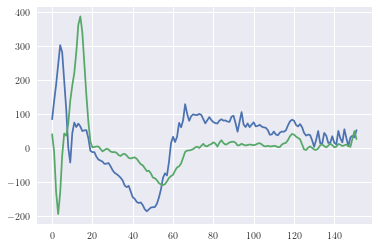

In [30]:
encoding, class_encoding, class_names = _get_encoding(dataset)

y_true = encoding.inverse_transform(y_test[rindex])
# print(np.argmax(y_true))
# print(class_names[np.argmax(y_true)])
plt.figure(figsize=(6, 4))
plt.plot(x[0])

In [31]:
# x = np.expand_dims(x, axis=0)
# x.shape

From our random sample, we have chosen a class of:

In [32]:
print(class_names[np.argmax(y_true)])

1


In [33]:
model.predict(x)

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


array([[0.19, 0.81]], dtype=float32)

2. Get output from Transformer Block

In [34]:
layer_name = "transformer_block"
model.get_layer(layer_name).output

<tf.Tensor 'transformer_block/layer_normalization_1/batchnorm/add_1:0' shape=(None, 152, 32) dtype=float32>

In [35]:
# predictions = tf.keras.layers.Dense(152, activation='softmax')(model.layers[-3].output)

3. Instantiate a new "Attention" model, whose output will be a vector representaiton of the weights coming from the Transformer block.

In [36]:
attmodel = Model(inputs=inputs, outputs=model.get_layer(layer_name).output)
# annmodel.compile(optimizer='adam', loss=WeightedLogLoss)

4. Get vector representation from our random sampled input from the test set

In [37]:
vector = attmodel.predict(x)
vector.shape

(1, 152, 32)

* Rearrange axis for easier visualisation

In [38]:
v = np.moveaxis(vector, 1, 2)
v.shape, vector.shape

((1, 32, 152), (1, 152, 32))

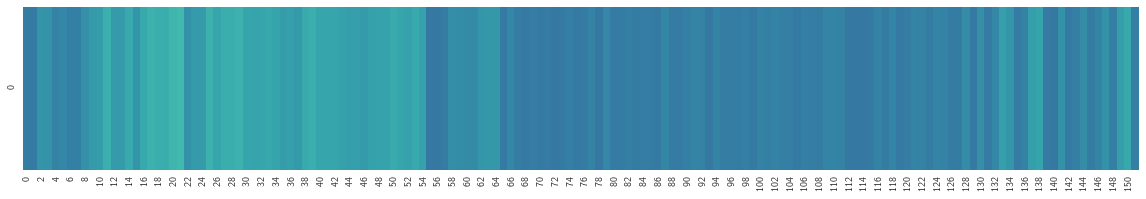

In [39]:
import seaborn as sns
cmap = sns.cm.mako
sns = sns.heatmap([np.abs(v[0][0])], cmap=cmap, cbar=False, vmin=v.min(), vmax=v.max())
plt.show()

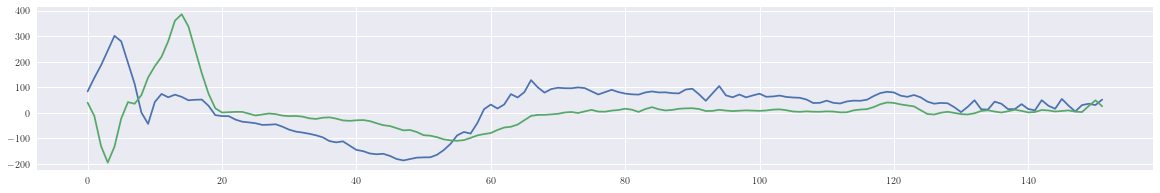

In [40]:
plt.plot(x[0])

* Note that darker reigons do not nessearily indicate low 'power' since the weights can range in magnitute from 'high' negative values to 'high' positive values